# Basic Statistics on TMS Postings

This notebook uses a csv file containing the composite of recordings from the TMS. Recordings began on 2/21/17 and were last done on 06/08/17. A few postings were removed from the TMS before 2/21/17, but the vast majority of positions available to 2017 PMF finalists were recorded. A verion of this csv file with some metadata universal to each posting (hiring agency, starting date, number of positions, location, etc.) is available in the github folder.

In [1]:
import pandas as pd #to write/read/work with csv files.
import numpy as np #to do math
import matplotlib.pyplot as plt #To make plots
import seaborn as sns #for additional plot features
%matplotlib inline
from datetime import timedelta #for accurate plotting of dates%matplotlib inline
from datetime import datetime #to deal with time
from bs4 import BeautifulSoup #to process html of saved postings
from wordcloud import WordCloud #to generate wordclouds

Definitions that I'll be using later in the script:

In [2]:
#creates a plot of the percent of total positions vs percent of positions
def TopPercentage(save):
    a=list(df2.loc[:,'Listings'].value_counts().index.values)
    a.sort()
    df_temp=pd.DataFrame();
    df_temp['Listings']=a
    #below, combining rows for same posting but different locations to get total positions for each posting
    x=0
    for elm in a:
        df_temp.loc[x,'Number of Openings']=df2.loc[df2.loc[:,'Listings']==elm,'Number of Positions'].sum()
        x=x+1
    #now sort by highest number of positions in posting
    b=df_temp.sort_values('Number of Openings', ascending=False)
    #calculating the percent of total positions represented by top n sorted postings
    b['Percentage']=0
    b.reset_index(inplace=True)
    del b['index']
    for x in range(0,len(b)):
        b.loc[x,'Percentage']=b.loc[0:x,'Number of Openings'].sum()/(df2.loc[:,'Number of Positions'].sum())
    #and finally plot the results
    b.plot(y='Percentage');
    plt.ylabel('Percent of total positions');
    plt.xlabel('Number of postings \n(sorted largest number of positions per posting to smallest)');
    plt.title('''Percentage of total available positions in top n postings
    50 percent of positions in top %s postings
    Last recording: %s'''%(b.loc[b.loc[:,'Percentage']>.5,:].index[0],date_of_last_scrape));
    plt.axhline(.5,color='black',linestyle='--');
    if save==True:
        plt.savefig('TopPercentage.png',bbox_inches='tight')

# First version of count plots (replaced by v2)
def count_plots(val,min_count,save):
    df_titleTypes=pd.DataFrame()
    df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
    df_titleTypes['Count']=0
    for x in range(0,len(df2)):
        df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
        df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
    df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
    df_titleTypes=df_titleTypes.loc[df_titleTypes.loc[:,'Count']>=min_count,:]
    df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[16,5])
    plt.xticks(rotation=90);
    plt.ylabel('Number of Positions')
    plt.title('Type and Frequency of %s for 2017 PMFs (with count >= %s)\nLast recording from TMS on %s'%(
            val, min_count,date_of_last_scrape));
    if save==True:
        plt.savefig('%s_%s.png'%(val.replace(' ','_').replace('/','_'),min_count),bbox_inches='tight')

#Creates a plot of postings and positions over time
def OverTime(save):
    df_time=pd.DataFrame()
    df_time['Days']=range(0,250) #can be changed to change temporal window of plot
    df_time['Positions']=0
    df_time['Postings']=0
    #counting up the number of positions and postings, plus including a timestamp for the days
    for x in range(0,len(df_time)):
        df_time.loc[x,'Date']=pd.Timestamp('20170101')+timedelta(days=x);
        df_time.loc[x,'Positions']=df2.loc[(df2.loc[:,'Opening Date 2'].dt.days<=x)&(
            df2.loc[:,'Closing Date 2'].dt.days>=x),'Number of Positions'].sum();
        df_time.loc[x,'Postings']=len(df2.loc[(df2.loc[:,'Opening Date 2'].dt.days<=x)&(
            df2.loc[:,'Closing Date 2'].dt.days>=x),'Listings'].unique());
    plt.plot(df_time['Date'],df_time['Positions'],label='Positions')
    plt.plot(df_time['Date'],df_time['Postings'],label='Postings')
    plt.ylabel('Number of Postings/Positions');
    plt.xlabel('Date');
    plt.legend(loc=2);
    plt.title('''Number of postings and positions available on TMS on a given day''');
    plt.axvline(pd.Timestamp('20170228'),color='black',linestyle='--',label='virtual hiring fair');
    plt.axvline(pd.Timestamp('20'+date),color='purple',linestyle='--',label='most recent recording');
    plt.legend(bbox_to_anchor=(1.01, 1),loc=2,borderaxespad=0.);
    plt.xticks(rotation=90);
    if save==True:
        plt.savefig('DailyPositionsPostings.png',bbox_inches='tight')

# Simple plot of number of days a posting was open. Making sure to not include duplicated posts for different cities
def opening_length(save):
    sns.countplot(df2.loc[~df2['Listings'].duplicated(),'Opening Length'].dt.days);
    plt.xticks(rotation=90);
    plt.title('Number of full days posting is up on TMS');
    if save==True:
        plt.savefig('Opening_lengths.png',bbox_inches='tight')

#A word cloud maker
def word_cloud(category, word_length,save):
    cat=category; #column of dataframe
    l=word_length #controls length of words included in word_cloud (common words are never included by module design)
    a=list(df2.loc[~df2['Listings'].duplicated(),cat].fillna('').values)
    b=' '.join(a)
    c=b.split(' ')
    d=[elm for elm in c if len(elm)>=l]
    wordcloud = WordCloud().generate(' '.join(d))
    fig = plt.figure(figsize = (8,20))
    plt.imshow(wordcloud, interpolation='bilinear');
    plt.axis("off");
    plt.title(cat+'\n(words with length >=%s)'%(l));
    if save==True:
        plt.savefig('%sWC_%s.png'%(cat,l),bbox_inches='tight')    

#plotting the top_n_labels in a category of a dataframe over time
def Temporal_distribution_top(category, top_n_labels,save):
    cat=category
    test=pd.DataFrame()
    y=top_n_labels
    for agency in list(df2.loc[:,cat].value_counts()[:y].keys()):
        a=df2.loc[(df2.loc[:,cat]==agency),:]
        h=agency;
        for x in range(0,250):
            test.loc[x,'Date']=pd.Timestamp('20170101')+timedelta(days=x)
            test.loc[x,'%s'%(h)]=a.loc[(a['Opening Date 2'].dt.days<=x)&(a['Closing Date 2'].dt.days>=x),'Number of Positions'].sum();
    ax=test.plot(x='Date');
    vhf=pd.Timestamp('20170228')
    plt.axvline(vhf,color='black',linestyle='--',label='Virtual Hiring Fair');
    last_rec=pd.Timestamp('20'+DOLS);
    plt.axvline(last_rec,color='grey',linestyle='--',label='Last TMS recording');
    plt.legend(bbox_to_anchor=(1.01, 1),loc=2,borderaxespad=0.);
    plt.xticks(rotation=90);
    plt.ylabel('positions');
    plt.xlabel('days from Jan. 1st');
    plt.title('Temporal distribution of select %s'%cat);
    if save==True:
        plt.savefig('TemporalDist%s_%s.png'%(cat,l),bbox_inches='tight') 

#plotting specific names/labels of a category over time
def Temporal_distribution_specific(category, names, save):
    catsafe=category.replace('/','-')
    test=pd.DataFrame()
    for agency in names:
        a=df2.loc[(df2.loc[:,category]==agency),:]
        h=agency;
        for x in range(0,250):
            test.loc[x,'Date']=pd.Timestamp('20170101')+timedelta(days=x)
            test.loc[x,'%s'%(h)]=a.loc[(a['Opening Date 2'].dt.days<=x)&(a['Closing Date 2'].dt.days>=x),'Number of Positions'].sum();
    ax=test.plot(x='Date');
    vhf=pd.Timestamp('20170228')
    plt.axvline(vhf,color='black',linestyle='--',label='Virtual Hiring Fair');
    last_rec=pd.Timestamp('20'+DOLS);
    plt.axvline(last_rec,color='grey',linestyle='--',label='Last TMS recording');
    plt.legend(bbox_to_anchor=(1.01, 1),loc=2,borderaxespad=0.);
    plt.xticks(rotation=90);
    plt.ylabel('Positions');
    plt.xlabel('Date');
    plt.title('Temporal distribution of select %s'%category);
    if save==True:
        plt.savefig('TemporalDist%s_Specific.png'%(catsafe),bbox_inches='tight')  

#does some work on the initial dataframe to make additional columns, add datetime functionality, etc.
def clean_expand():
    for x in range(0,len(df2)):
        try:
            a=BeautifulSoup(df2.loc[x,'HTML'], "html.parser")
            a=a.text.replace('\t','').replace('\r','').replace('\xa0','').replace('\x95','').replace('\x92','')
            b=a.split('\n')
            c=b[b.index('Description of Organization')+1:b.index('Description of Position')];
            d='';
            for y in range(0,len(c)):
                d=d+' '+c[y]
            df2.loc[x,'Description of Organization']=d
            d=''
            c=b[b.index('Description of Position')+1:b.index('Qualifications for the Position')]
            d='';
            for y in range(0,len(c)):
                d=d+' '+c[y]
            df2.loc[x,'Description of Position']=d
            c=b[b.index('Qualifications for the Position')+1:b.index('How to Apply Instructions')]
            d='';
            for y in range(0,len(c)):
                d=d+' '+c[y]
            df2.loc[x,'Qualifications for the Position']=d
            c=b[b.index('How to Apply Instructions')+1:b.index('NOTE: Contact the Agency Contact identified above for any questions. If you have specific agency questions, contact the Agency PMF Coordinator. ')]
            d='';
            for y in range(0,len(c)):
                d=d+' '+c[y]
            df2.loc[x,'How to Apply Instructions']=d
        except:
            pass   
    df2.loc[:,'Agency']=df2.loc[:,'Agency/Sub-Agency'].str.split(' / ').str[0]
    df2['Opening Date']=pd.to_datetime(df2['Opening Date'])
    df2['Closing Date']=pd.to_datetime(df2['Closing Date'])
    df2['Opening Date 2']=df2.loc[:,'Opening Date']-pd.Timestamp('20170101')
    df2['Closing Date 2']=df2.loc[:,'Closing Date']-pd.Timestamp('20170101')
    df2['Opening Length']=pd.to_datetime(df2.loc[:,'Closing Date'],'%Y %m %d')-pd.to_datetime(df2.loc[:,'Opening Date'],'%Y %m %d')

#second attempt ot count_plot. Now includes percent of total line
def count_plotsv2(col,n,save):
    df_a=pd.DataFrame();
    #col='State'
    df_a['Category']=df2[col].unique()
    df_a['Count']=0
    x=0
    for x in range(0,len(df_a)):
        df_a.loc[x,'Count']=df2.loc[df2.loc[:,col]==df_a.loc[x,'Category'],'Number of Positions'].sum()
    df_a=df_a.sort_values('Count',ascending=False)
    df_a.reset_index(inplace=True)
    del df_a['index']
    df_a['Percent Total']=0
    for x in range(0,len(df_a)):
        df_a.loc[x,'Percent Total']=df_a.loc[0:x,'Count'].sum()/df_a.Count.sum()

    fig, ax1 = plt.subplots()
    color1='blue'
    color2='black'
    ax1.bar(df_a.index[0:n],df_a['Count'][0:n],color=color1,align='center')
    ax1.set_ylabel('Number of Positions', color=color1)
    #ax1.yaxis below set to always go to the next highest unit of 100 and always have 11 ticks. Matchs ax2
    ax1.yaxis.set_ticks(np.arange(0, round(df_a['Count'].max()+50,-2)+1,round(df_a['Count'].max()+50,-2)/10))
    ax1.tick_params('y', colors=color1)
    plt.xticks(np.arange(min(df_a.index), max(df_a.index)+0, 1.0))
    ax1.set_xlabel(col)
    ax1.set_xticklabels(df_a['Category'],rotation=90)

    ax2 = ax1.twinx()
    ax2.plot(df_a.index[0:n],df_a['Percent Total'][0:n],color=color2,linestyle='--',linewidth=5)
    ax2.set_ylabel('Percent of Total Positions', color=color2)
    ax2.yaxis.set_ticks(np.arange(0.,1.1, .1))
    #ax2.set_yticks(np.linspace(ax2.get_yticks()[0],ax2.get_yticks()[-1],len(ax1.get_yticks())));
    ax2.tick_params('y', colors=color2)
    plt.title('Available Positions per %s (top %s shown) for 2017'%(col,n));
    if save==True:
        plt.savefig('%s_%s.png'%(col.replace(' ','_').replace('/','_'),n),bbox_inches='tight')

#2nd attempt at word_cloud. Now allows for keyword to only look at subset of column's values.
def word_cloudv2(category, keyword,word_length,save):
    cat=category;
    l=word_length
    kw=keyword
    a=list(df2.loc[(~df2['Listings'].duplicated())&(df2.loc[:,cat].str.contains(kw)),cat].fillna('').values)
    #a=list(df2.loc[:,cat].values)
    b=' '.join(a)
    c=b.split(' ')
    d=[elm for elm in c if len(elm)>=l]
    wordcloud = WordCloud().generate(' '.join(d))
    fig = plt.figure(figsize = (8,20))
    plt.imshow(wordcloud, interpolation='bilinear');
    plt.axis("off");
    plt.title(cat+' word cloud with keyword: %s\n(words with length >=%s)'%(keyword,l));
    if save==True:
        plt.savefig('%sWC_KW%s_%s.png'%(category,keyword,word_length),bbox_inches='tight')    

Opening csv file into a pandas dataframe, labeled df2 for historical reasons

In [3]:
df2=pd.read_csv('meta_composite2.csv',encoding='ISO-8859-1')
date_of_last_scrape='08/28/2017'
a=date_of_last_scrape.split('/')
date=a[2][-2:]+a[0]+a[1]
DOLS=date;

<b>All the definitions used in this notebook are in the final cell at the bottom. Run that cell before continuing.</b>

clean_expand does additional work on df2 (converting text to datetime entries, breaking apart the html, etc). The rest of the definitions used in this notebook assume clean_expand has already been run.

In [4]:
clean_expand()

Before continuing, a short cell to save a GitHub prepared version of the metadata in df2.

In [5]:
df2.loc[:,['Listings','Series','Position Title', 'Number of Positions', 'Agency',
           'Agency/Sub-Agency','State','Opening Date','Closing Date',
           'Opening Length','GS-09','GS-11','GS-12','GS-13',
           'Promotion Potential']].to_csv('meta_composite_GitHub.csv',index=False)

Two useful numbers: number of postings and number of positions made available on the TMS over the course of this project.

In [6]:
BasicStats=pd.DataFrame()
BasicStats.loc[0,'Number of Postings']=len(df2.Listings.value_counts().index)
BasicStats.loc[0,'Number of Positions']=df2['Number of Positions'].sum()
BasicStats.loc[0,'Positions per Finalist']=BasicStats.loc[0,'Number of Positions']/417
BasicStats

,Number of Postings,Number of Positions,Positions per Finalist
0,521.0,1174.0,2.815348


Finally, some definitions to generate plots that help provide analysis of what's going on in the TMS.

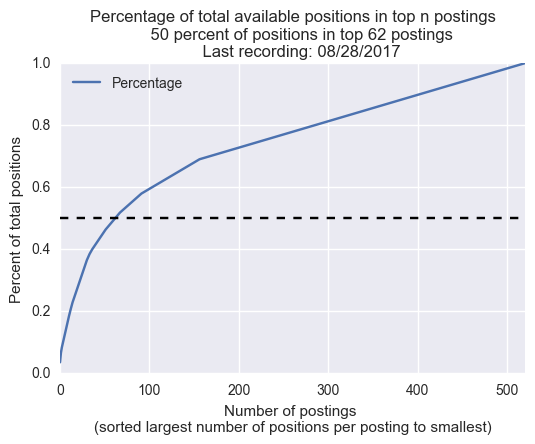

In [7]:
TopPercentage(True)

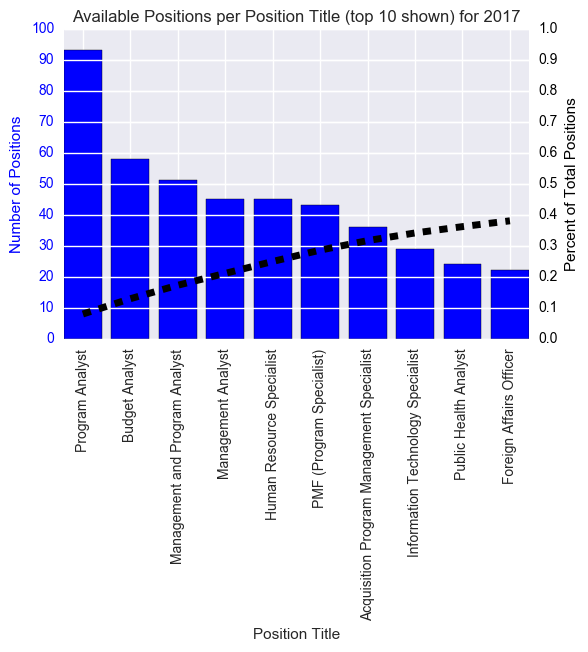

In [8]:
count_plotsv2('Position Title',10,True)

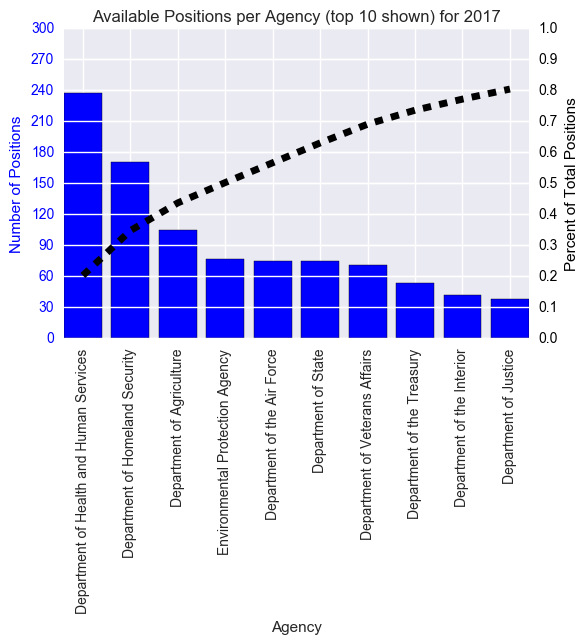

In [9]:
count_plotsv2('Agency',10,True)

In [10]:
len(df2.Agency.unique())

35

In [11]:
a=df2.loc[df2.loc[:,'Agency']=='Department of Health and Human Services','Number of Positions'].sum()
b=df2.loc[df2.loc[:,'Agency']=='Department of Homeland Security','Number of Positions'].sum()
c=df2.loc[df2.loc[:,'Agency']=='Department of Agriculture','Number of Positions'].sum()
d=df2.loc[df2.loc[:,'Agency']=='Department of the Air Force','Number of Positions'].sum()
total=df2.loc[:,'Number of Positions'].sum()
print((a+b+c)/total)

0.43611584327086883


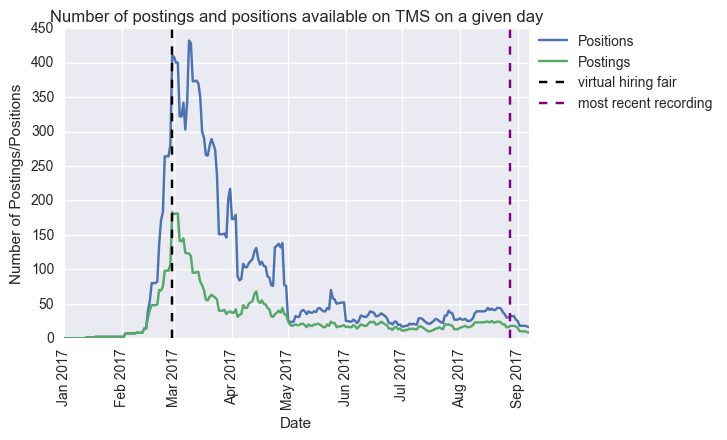

In [12]:
OverTime(True)

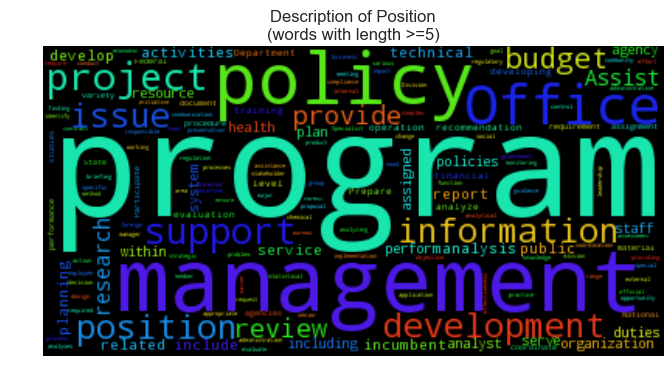

In [13]:
word_cloud('Description of Position',5,True)

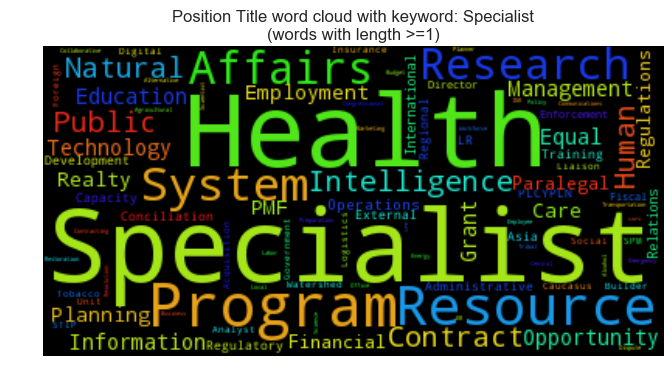

In [14]:
word_cloudv2('Position Title','Specialist',1,True)

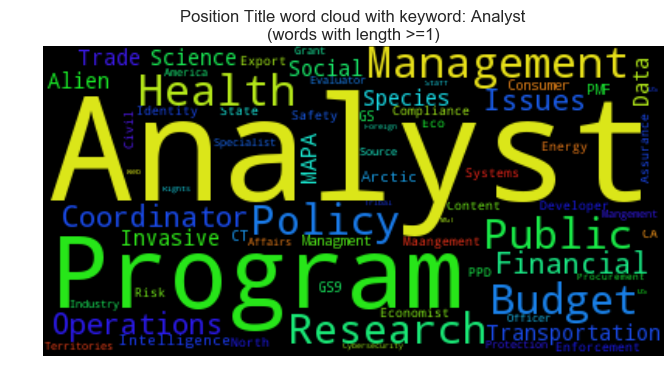

In [15]:
word_cloudv2('Position Title','Analyst',1,True)

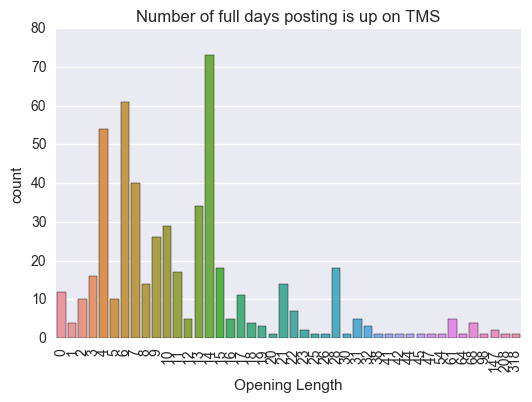

In [16]:
opening_length(True)

In [17]:
df2.loc[:,'Opening Length'].median()

Timedelta('10 days 00:00:00')

These next few cells calculate the percent of total for various values in particular columns.

For example, this one find the percent of Position Titles that have Analyst of Specialist in the name:

In [18]:
a_A=df2.loc[df2.loc[:,'Position Title'].str.contains('Analyst'),'Number of Positions'].sum();
a_S=df2.loc[df2.loc[:,'Position Title'].str.contains('Specialist'),'Number of Positions'].sum();
b=df2.loc[:,'Number of Positions'].sum()
print('Position Titles with Analyst in the name account for %s of the total positions available'%(round(a_A/b*100,1)))
print('Position Titles with Specialist in the name account for %s of the total positions available'%(round(a_S/b*100,1)))
print('Position Titles with both in the name account for %s of the total positions available'%(round((a_A+a_S)/b*100,1)))

Position Titles with Analyst in the name account for 37.1 of the total positions available
Position Titles with Specialist in the name account for 34.5 of the total positions available
Position Titles with both in the name account for 71.6 of the total positions available


Can also look at State values:

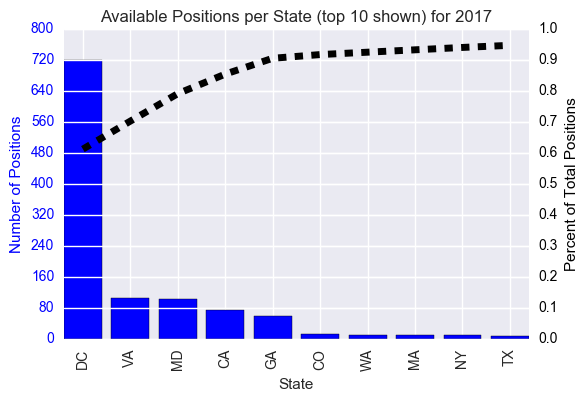

In [19]:
count_plotsv2('State',10,True)

In [20]:
a_DC=df2.loc[df2.loc[:,'State']=='DC','Number of Positions'].sum()
a_VA=df2.loc[df2.loc[:,'State']=='VA','Number of Positions'].sum()
a_MD=df2.loc[df2.loc[:,'State']=='MD','Number of Positions'].sum()
b=df2.loc[:,'Number of Positions'].sum()
print('%s of the total positions are in DC'%(round(a_DC/b*100,1)))
print('%s of the total positions are in VA'%(round(a_VA/b*100,1)))
print('%s of the total positions are in MD'%(round(a_MD/b*100,1)))
print('%s of the total positions are in all three'%(round((a_DC+a_VA+a_MD)/b*100,1)))

61.2 of the total positions are in DC
9.0 of the total positions are in VA
8.9 of the total positions are in MD
79.1 of the total positions are in all three


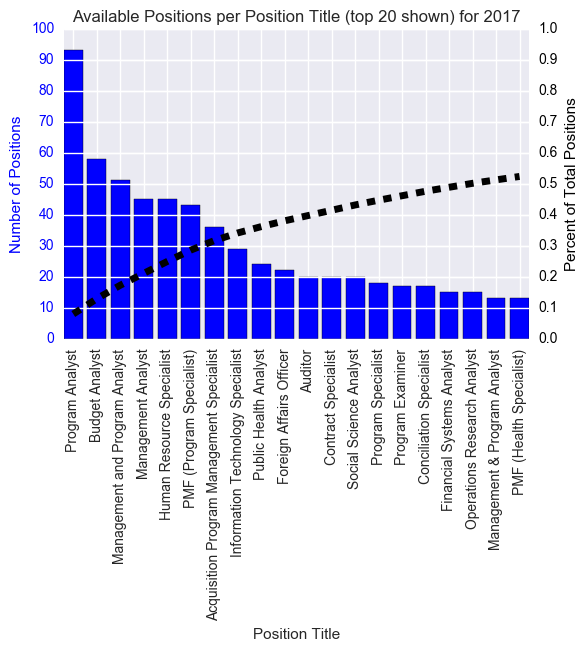

In [21]:
count_plotsv2('Position Title',20,True)

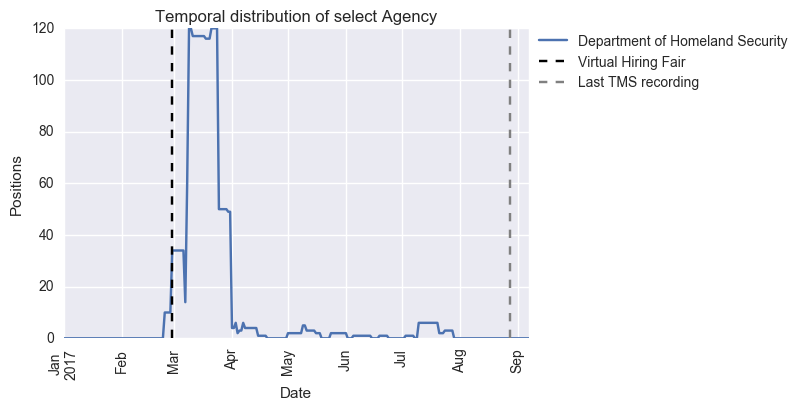

In [22]:
Temporal_distribution_specific('Agency', ['Department of Homeland Security'], False)

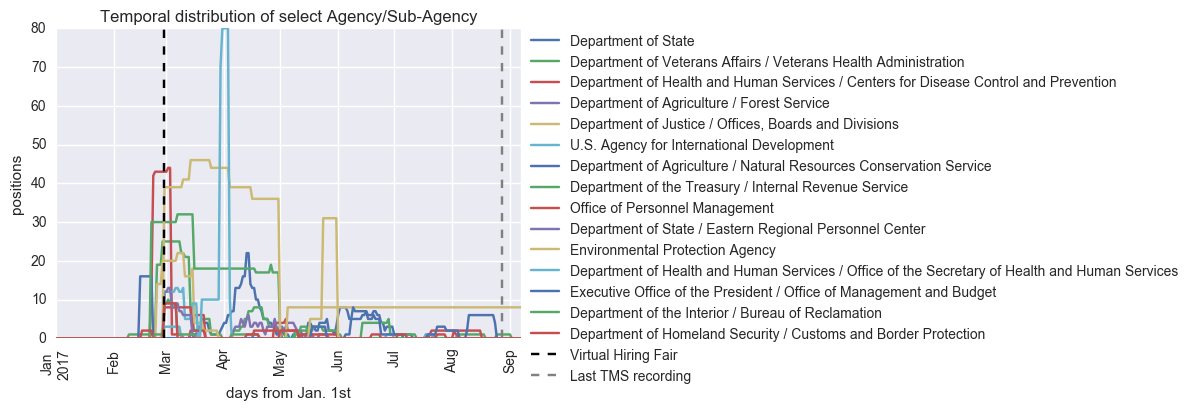

In [23]:
Temporal_distribution_top('Agency/Sub-Agency',15,False)

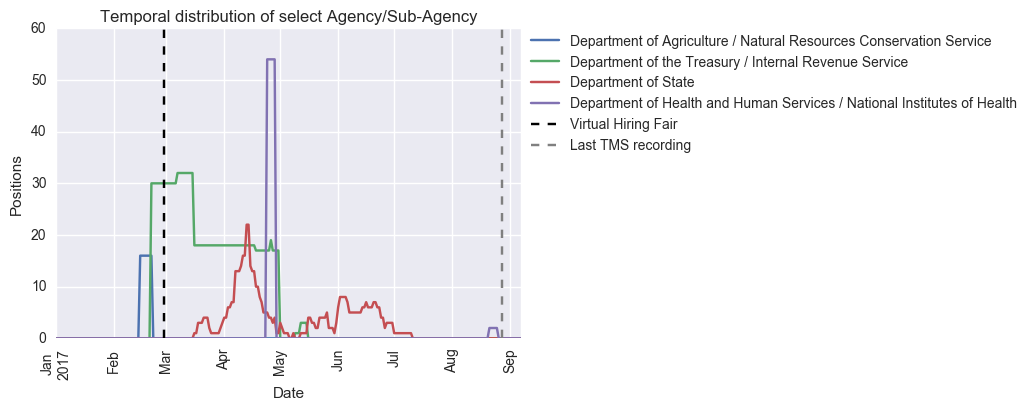

In [24]:
Temporal_distribution_specific('Agency/Sub-Agency', [
        'Department of Agriculture / Natural Resources Conservation Service',
        'Department of the Treasury / Internal Revenue Service',
        'Department of State','Department of Health and Human Services / National Institutes of Health'], True)

Job titles not with Analyst of Specialist in them

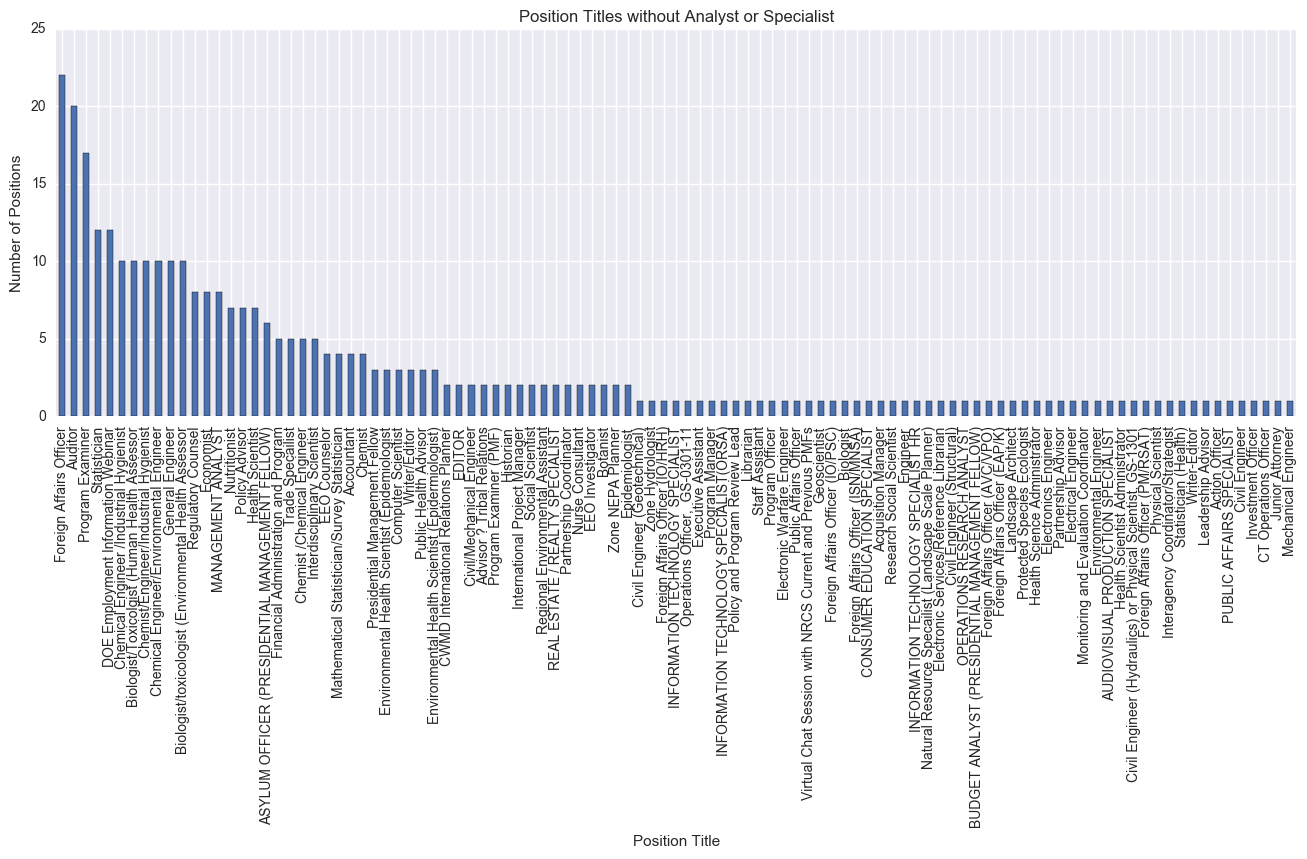

In [25]:
val='Position Title'
min_count=0
df_titleTypes=pd.DataFrame()
df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
df_titleTypes['Count']=0
for x in range(0,len(df2)):
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
df_titleTypes=df_titleTypes.loc[df_titleTypes.loc[:,'Count']>=min_count,:]
df_titleTypes=df_titleTypes.loc[~(df_titleTypes.loc[:,'Position Title'].str.contains('Analyst'))&~(
    df_titleTypes.loc[:,'Position Title'].str.contains('Specialist')),:]
df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[16,5])
plt.xticks(rotation=90);
plt.ylabel('Number of Positions');
plt.title('Position Titles without Analyst or Specialist');
plt.savefig('NonAnalystSpecialist.png',bbox_inches='tight')